In [1]:
import os
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert
import pickle
import ipywidgets as widgets

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils, stamp_correction

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

# CAP whole

In [2]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT'
}
print_dataset_names = {
    (constants.CAP_SS_NAME, 1): "CAP-A7",
    (constants.CAP_SS_NAME, 2): "CAP-S1",
    (constants.CAP_SS_NAME, 3): "CAP-S2",
}
eval_configs = [
    dict(dataset_name=constants.CAP_SS_NAME, expert=2, strategy='5cv', seeds=1),
    dict(dataset_name=constants.CAP_SS_NAME, expert=3, strategy='5cv', seeds=1),
    dict(dataset_name=constants.CAP_SS_NAME, expert=1, strategy='5cv', seeds=1),
]

metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions_for_cap_whole(model_version, dataset, config["expert"], verbose=True)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    valid_subjects = dataset.all_ids
    for model_name in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_list.append(table)
print("Done.")


Loading {'dataset_name': 'cap_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 1}
Loading predictions from 20210621_thesis_whole_5cv_e2_n2_train_cap_ss/v2_time_subjectsize100.0
Loading predictions from 20210621_thesis_whole_5cv_e2_n2_train_cap_ss/v2_cwt1d_subjectsize100.0

Loading {'dataset_name': 'cap_ss', 'expert': 3, 'strategy': '5cv', 'seeds': 1}
Loading predictions from 20210621_thesis_whole_5cv_e3_n2_train_cap_ss/v2_time_subjectsize100.0
Loading predictions from 20210621_thesis_whole_5cv_e3_n2_train_cap_ss/v2_cwt1d_subjectsize100.0

Loading {'dataset_name': 'cap_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 1}
Loading predictions from 20210621_thesis_whole_5cv_e1_n2_train_cap_ss/v2_time_subjectsize100.0
Loading predictions from 20210621_thesis_whole_5cv_e1_n2_train_cap_ss/v2_cwt1d_subjectsize100.0
Done.


In [3]:
# Tabla desempeño by-fold
print("Datos & Detector & F1-score (\%) & Recall (\%) & Precision (\%) & mIoU (\%) \\\\")
for i_config, config in enumerate(eval_configs):
    table = metrics_list[i_config]
    # Form by-fold metrics (it is macro-average for each fold)
    table_fold = table.drop(columns=["Subject"]).groupby(by=["Detector", "Fold"]).mean().reset_index()  # macro-avg
    table_fold_mean = table_fold.drop(columns=["Fold"]).groupby(by=["Detector"]).mean().add_suffix("_mean")
    table_fold_std = table_fold.drop(columns=["Fold"]).groupby(by=["Detector"]).std(ddof=0).add_suffix("_std")
    table_fold_stat = table_fold_mean.join(table_fold_std).reset_index()
    
    dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
    print("\n%s" % dataset_str)
    table_fold_stat = table_fold_stat.set_index('Detector').to_dict(orient='index')
    for model_name in models:
        metrics_model = table_fold_stat[model_name]
        metric_str = "& %s & %s & %s & %s & %s \\\\" % (
            print_model_names[model_name].ljust(10),
            fig_utils.format_metric(metrics_model['F1-score_mean'], metrics_model['F1-score_std']),
            fig_utils.format_metric(metrics_model['Recall_mean'], metrics_model['Recall_std']),
            fig_utils.format_metric(metrics_model['Precision_mean'], metrics_model['Precision_std']),
            fig_utils.format_metric(metrics_model['mIoU_mean'], metrics_model['mIoU_std']),
        )
        print(metric_str)
        
    # Statistical tests
    time_metrics = table_fold[table_fold["Detector"] == constants.V2_TIME]['F1-score'].values
    cwt_metrics = table_fold[table_fold["Detector"] == constants.V2_CWT1D]['F1-score'].values
    pvalue = stats.ttest_ind(cwt_metrics, time_metrics, equal_var=False)[1]
    print("%s vs %s: P %1.4f" % (print_model_names[constants.V2_CWT1D], print_model_names[constants.V2_TIME], pvalue))

Datos & Detector & F1-score (\%) & Recall (\%) & Precision (\%) & mIoU (\%) \\

CAP-S1
& REDv2-Time & $95.5\pm 0.4$ & $96.1\pm 0.5$ & $94.9\pm 0.5$ & $94.7\pm 0.2$ \\
& REDv2-CWT  & $96.1\pm 0.3$ & $96.4\pm 0.4$ & $95.8\pm 0.5$ & $95.2\pm 0.2$ \\
REDv2-CWT vs REDv2-Time: P 0.0615

CAP-S2
& REDv2-Time & $82.2\pm 1.0$ & $85.2\pm 4.5$ & $82.3\pm 3.3$ & $88.0\pm 0.6$ \\
& REDv2-CWT  & $82.4\pm 0.9$ & $84.4\pm 4.5$ & $83.3\pm 3.9$ & $88.5\pm 0.2$ \\
REDv2-CWT vs REDv2-Time: P 0.7461

CAP-A7
& REDv2-Time & $88.1\pm 0.3$ & $89.5\pm 1.8$ & $87.2\pm 1.4$ & $88.3\pm 0.4$ \\
& REDv2-CWT  & $88.2\pm 0.4$ & $89.5\pm 2.2$ & $87.5\pm 1.7$ & $88.2\pm 0.5$ \\
REDv2-CWT vs REDv2-Time: P 0.5632


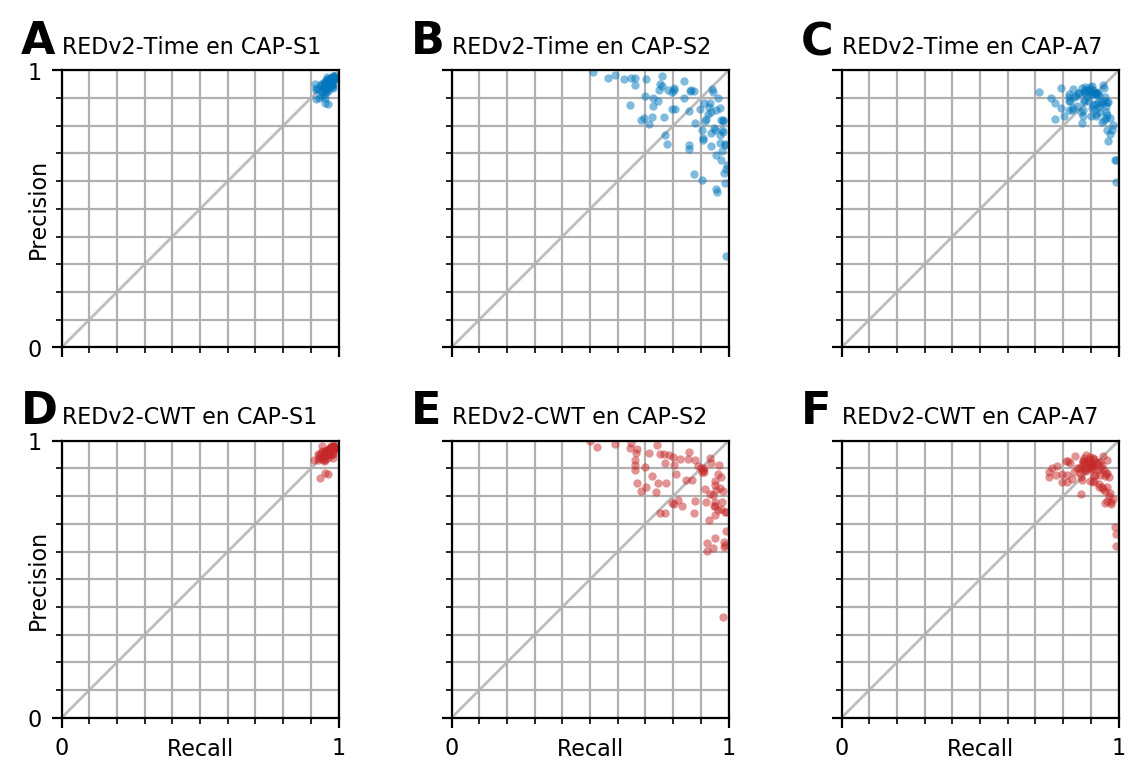

In [4]:
# PR by-subject
save_figure = False

colors = {constants.V2_TIME: viz.PALETTE['blue'], constants.V2_CWT1D: viz.PALETTE['red']}
marker_size = 3
marker_alpha = 0.5
letters = [['A', 'B', 'C'], ['D', 'E', 'F']]
fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=200, sharex=True, sharey=True)

for i_config, config in enumerate(eval_configs):
    table = metrics_list[i_config]
    # Form by-subject metrics 
    table_subject = table.drop(columns=["Fold"]).groupby(by=["Detector", "Subject"]).mean().reset_index()  # subject avg
    for j, model_version in enumerate(models):
        ax = axes[j, i_config]
        
        table_model = table_subject[table_subject['Detector'] == model_version]
        recalls = table_model['Recall'].values
        precisions = table_model['Precision'].values
        
        # Draw
        ax.plot(
            recalls, precisions, color=colors[model_version], linestyle='None', alpha=marker_alpha,
            markeredgewidth=0.0, marker='o', markersize=marker_size)
        model_str = print_model_names[model_version]
        dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
        ax.set_title('%s en %s' % (model_str, dataset_str), fontsize=8, loc="left")
        
        # subjects = table_model['Subject'].values
        # print("\n", dataset_str, model_str)
        # sorted_locs = np.argsort(precisions)
        # for loc in sorted_locs:
        #     this_prec = precisions[loc]
        #     this_subject = subjects[loc]
        #     if this_prec < 0:
        #         print("Subject %s, Precision %1.1f" % (this_subject, this_prec * 100))
        
        ax.text(
            x=-0.15, y=1.06, fontsize=16, s=r"$\bf{%s}$" % letters[j][i_config],
            ha="left", transform=ax.transAxes)

        
for ax in axes.flatten():
    plotter.format_precision_recall_plot_simple(
        ax, axis_range=(0.0, 1.0), 
        show_quadrants=False, show_grid=True, 
        axis_markers=[0, 1], minor_axis_markers=np.arange(0, 1 + 0.001, 0.1))
    ax.tick_params(labelsize=8)
    # Get labels closer to axis
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8

for ax in axes[:, 0]:
    ax.set_ylabel("Precision", fontsize=8)
for ax in axes[1, :]:
    ax.set_xlabel("Recall", fontsize=8)
    
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_indata_cap_whole_pr"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

In [5]:
outliers_by_expert = {
    1: ['3-001', '1-012', '1-009'],  # cap-a7
    2: ['7-019', '8-001', '7-021'],  # cap-s1
    3: ['7-016'],  # cap-s2
}

In [6]:
# Load CAP-A7
expert = 1

dataset = reader.load_dataset(constants.CAP_SS_NAME, verbose=False)
pred_dict = {}
for model_version in models:
    tmp_dict = fig_utils.get_red_predictions_for_cap_whole(model_version, dataset, expert, verbose=True)
    # Retrieve only predictions, same format as baselines
    pred_dict[model_version] = {}
    for k in tmp_dict.keys():
        fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
        fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
        pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
print("Done.")

Loading predictions from 20210621_thesis_whole_5cv_e1_n2_train_cap_ss/v2_time_subjectsize100.0
Loading predictions from 20210621_thesis_whole_5cv_e1_n2_train_cap_ss/v2_cwt1d_subjectsize100.0
Done.


In [33]:
model_version = constants.V2_CWT1D
subjects_of_interest = outliers_by_expert[expert]

subject_parameters = {}
for k in range(5):
    fold_subjects = list(pred_dict[model_version][k].keys())
    for subject_id in fold_subjects:
        if subject_id not in subjects_of_interest:
            continue
        subject_dets = pred_dict[model_version][k][subject_id]
        subject_annots = dataset.get_subject_stamps(subject_id, which_expert=expert, pages_subset='n2')
        # identify TP and FP
        iou_values, idx_values = metrics.matching(subject_annots, subject_dets)
        false_dets_locs = [loc for loc in range(subject_dets.shape[0]) if loc not in idx_values]
        true_annots_locs = np.where(idx_values != -1)[0]
        fp_events = subject_dets[false_dets_locs]
        tp_events = subject_annots[true_annots_locs]
        # compute parameters
        signal = dataset.get_subject_signal(subject_id, normalize_clip=False, which_expert=expert)
        filt_signal = param_filtering_fn(signal, dataset.fs, constants.SPINDLE)
        signal_tp = [filt_signal[e[0]:(e[1]+1)] for e in tp_events]
        signal_fp = [filt_signal[e[0]:(e[1]+1)] for e in fp_events]
        be_frequency_tp = np.array([param_frequency_fn(s, dataset.fs) for s in signal_tp])
        be_frequency_fp = np.array([param_frequency_fn(s, dataset.fs) for s in signal_fp])
        subject_parameters[subject_id] = {
            'frequency_tp':  be_frequency_tp,
            'frequency_fp': be_frequency_fp
        }
print("Done.")

Done.


1-012 precision 0.7113606340819022
1-009 precision 0.7139141742522757
3-001 precision 0.657051282051282


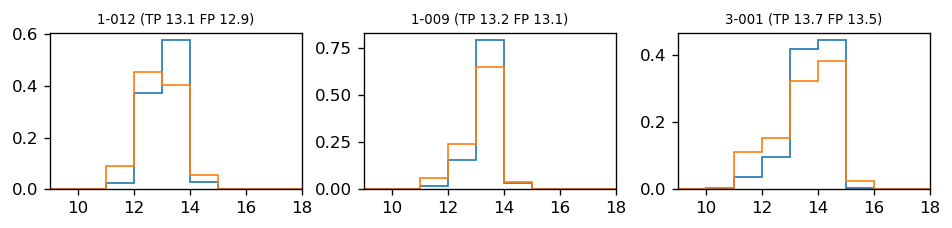

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2), dpi=120)
bins = np.arange(9, 18 + 0.001, 1)
for i, subject_id in enumerate(subject_parameters.keys()):
    ax = axes[i]
    ax.hist(subject_parameters[subject_id]['frequency_tp'], density=True, histtype="step", bins=bins)
    ax.hist(subject_parameters[subject_id]['frequency_fp'], density=True, histtype="step", bins=bins)
    n_tp = np.sum(subject_parameters[subject_id]['frequency_tp']>12.5)
    n_fp = np.sum(subject_parameters[subject_id]['frequency_fp']>12.5)
    precision = n_tp / (n_tp + n_fp)
    print(subject_id, "precision", precision)
    ax.set_xlim([9, 18])
    ax.set_title("%s (TP %1.1f FP %1.1f)" % (
        subject_id, 
        np.mean(subject_parameters[subject_id]['frequency_tp']),
        np.mean(subject_parameters[subject_id]['frequency_fp']),
    ), fontsize=8)
plt.tight_layout()
plt.show()